# Kaggle: Spaceship Titanic

## Libraries

In [1]:
import pandas as pd
import numpy as np 

# Scikit-learn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import clone, BaseEstimator, TransformerMixin
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Visualisation 
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['font.family'] = "Times New Roman"
plt.style.use("default")

## Get the data

In [2]:
df = pd.read_csv("train.csv")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
None


## Data Exploration
- Number of observations: There are 8693 observations 
- There are 7 categorical predictor variables, 7 quantitative predictor variables and a categorical response variable
-------------------------
- PassengerId: A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- HomePlanet: The planet the passenger departed from, typically their planet of permanent residence.
- CryoSleep: Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- Cabin: The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- Destination: The planet the passenger will be debarking to.
- Age: The age of the passenger.
- VIP: Whether the passenger has paid for special VIP service during the voyage.
- RoomService, FoodCourt, ShoppingMall, Spa, VRDeck: Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- Name: The first and last names of the passenger.
- Transported: Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [3]:
categorical_mask = (df.dtypes == object)
categorical_variables = df.columns[categorical_mask]
numerical_variables = df.columns[~categorical_mask]
print("Categorical Predictors: ")
print(categorical_variables)
print("Numerical Predictors: ")
print(numerical_variables)

Categorical Predictors: 
Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP',
       'Name'],
      dtype='object')
Numerical Predictors: 
Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Transported'],
      dtype='object')


### Quantitative Predictor Variables
- Age, RoomService, FoodCourt, ShoppingMall, Spa, VRDeck, Transported

In [4]:
print(df.loc[:,numerical_variables])

       Age  RoomService  FoodCourt  ShoppingMall     Spa  VRDeck  Transported
0     39.0          0.0        0.0           0.0     0.0     0.0        False
1     24.0        109.0        9.0          25.0   549.0    44.0         True
2     58.0         43.0     3576.0           0.0  6715.0    49.0        False
3     33.0          0.0     1283.0         371.0  3329.0   193.0        False
4     16.0        303.0       70.0         151.0   565.0     2.0         True
...    ...          ...        ...           ...     ...     ...          ...
8688  41.0          0.0     6819.0           0.0  1643.0    74.0        False
8689  18.0          0.0        0.0           0.0     0.0     0.0        False
8690  26.0          0.0        0.0        1872.0     1.0     0.0         True
8691  32.0          0.0     1049.0           0.0   353.0  3235.0        False
8692  44.0        126.0     4688.0           0.0     0.0    12.0         True

[8693 rows x 7 columns]


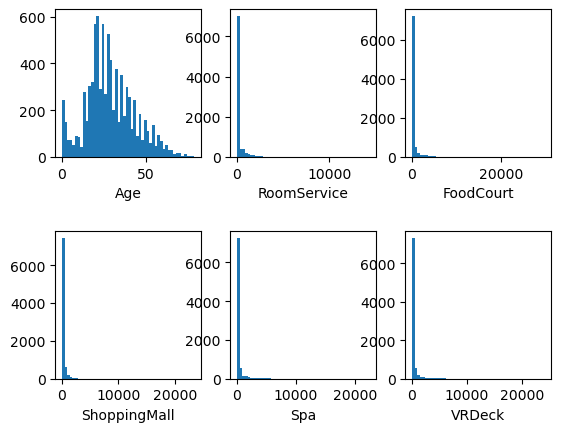

In [5]:
fig, axes = plt.subplots(nrows = 2, ncols = 3)
fig.subplots_adjust(hspace = 0.5)
for i in range(0,2,1):
    for j in range(0,3,1):
        variable_index = i*3 + j
        variable = numerical_variables[variable_index]
        axes[i,j].hist(df.loc[:,variable], bins = 50)
        axes[i,j].set_xlabel(variable)
plt.show()

- RoomService, FoodCourt, ShoppingMall, Spa and VR deck are all extremely skewed and so I will need to log transform these variables.

### Categorical Predictors
- PassengerID, HomePlanet, CrypoSleep, Cabin, Destination, VIP, Name

In [6]:
for variable in categorical_variables:
    print(pd.value_counts(df.loc[:,variable]))

0001_01    1
6136_01    1
6141_01    1
6139_06    1
6139_05    1
          ..
3126_01    1
3124_03    1
3124_02    1
3124_01    1
9280_02    1
Name: PassengerId, Length: 8693, dtype: int64
Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64
False    5439
True     3037
Name: CryoSleep, dtype: int64
G/734/S     8
G/109/P     7
B/201/P     7
G/1368/P    7
G/981/S     7
           ..
G/556/P     1
E/231/S     1
G/545/S     1
G/543/S     1
F/947/P     1
Name: Cabin, Length: 6560, dtype: int64
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64
False    8291
True      199
Name: VIP, dtype: int64
Gollux Reedall        2
Elaney Webstephrey    2
Grake Porki           2
Sus Coolez            2
Apix Wala             2
                     ..
Jamela Griffy         1
Hardy Griffy          1
Salley Mckinn         1
Mall Frasp            1
Propsh Hontichre      1
Name: Name, Length: 8473, dtype: int64


- PassengerID cannot be used as a feature since each passenger has a unique ID.
- Name cannot be used as a feature
- Cabin needs to be transformed so we classify the deck and side

## Preparing the Data
- Drop PassengerId and Name variables
- Impute and log transform the numerical predictor variables
- Create deck and side categorical predictor variables
- Impute and one-hot encode the categorical predictor variables

In [7]:
class CabinTransformer(BaseEstimator, TransformerMixin):
    """
    Transforms the cabin column into two categorical predictor variables representing the deck and the side
    (these can then be OneHotEncoded)
    """
    def __init__(self, cabin_index):
        self.cabin_index = cabin_index
    def fit(self, X, y = None):
        return self
    def transform(self, X):
        cabin_arr = X[:,self.cabin_index]
        cabin_series = pd.Series(cabin_arr)
        deck_series = cabin_series.str[0]
        side_series = cabin_series.str[-1]
        return np.concatenate([deck_series.values.reshape(-1,1), side_series.values.reshape(-1,1)], axis = 1)

In [8]:
X_test = pd.read_csv("test.csv")
X_train = df.drop(columns = "Transported")
y_train = df.loc[:,"Transported"]

variables_to_drop =["PassengerId","Name"]
X_test.drop(columns = variables_to_drop, inplace = True)
X_train.drop(columns = variables_to_drop, inplace = True)

categorical_mask = (X_train.dtypes == object)
categorical_predictors = X_train.columns[categorical_mask]
numerical_predictors = X_train.columns[~categorical_mask]

cabin_index = list(X_train.columns).index("Cabin")

num_pipeline = Pipeline([
("imputer",SimpleImputer(strategy = "median")),
("pow_trans",PowerTransformer())
])

cat_pipeline = Pipeline([
("imputer",SimpleImputer(strategy = "most_frequent")),
("cabin",CabinTransformer(cabin_index)),
("encoder",OneHotEncoder())
])

full_pipeline = ColumnTransformer([
("num",num_pipeline,numerical_predictors),
("cat",cat_pipeline,categorical_predictors)
])

X_train_transformed = full_pipeline.fit_transform(X_train)
X_test_transformed = full_pipeline.transform(X_test)

## Selecting and Training a Model
- I will use 10-fold cross-validation to evaluate Logistic Regression and Linear Discriminant Analysis models and select the best model based on the estimate of the test error rate and the ROC curve.

In [9]:
def StratifiedKFoldCV(estimator, X, y, cv = 10):
    cv_test_error_rate_lst = []
    skfolds = StratifiedKFold(n_splits = cv, shuffle = True, random_state = 42)
    
    for train_index, test_index in skfolds.split(X, y):
        X_train = X[train_index]
        y_train = y[train_index]
        
        X_test = X[test_index]
        y_test = y[test_index]
        
        clone_clf = clone(estimator)
        clone_clf.fit(X_train, y_train)
        
        y_test_pred = clone_clf.predict(X_test)
        
        cv_test_error_rate = 1 - accuracy_score(y_test, y_test_pred)
        cv_test_error_rate_lst.append(cv_test_error_rate)
    return np.mean(cv_test_error_rate_lst)


In [10]:
log_reg = LogisticRegression(max_iter = 1000)
cv_test_mse = StratifiedKFoldCV(log_reg, X_train_transformed, y_train, cv = 10)
y_train_cv_pred = cross_val_predict(log_reg, X_train_transformed, y_train, cv = 10)
roc_auc = roc_auc_score(y_train, y_train_cv_pred)
confusion_arr = confusion_matrix(y_train, y_train_cv_pred)
confusion_df = pd.DataFrame(confusion_arr, columns = [["Predicted","Predicted"],["Negative","Positive"]], index = [["Actual","Actual"],["Negative","Positive"]])
print(f"CV Test Error Rate Estimate {cv_test_mse}")
print(f"ROC Area Under Curve {roc_auc}")
print(confusion_df)

CV Test Error Rate Estimate 0.2543450656719972
ROC Area Under Curve 0.7444794551076249
                Predicted         
                 Negative Positive
Actual Negative      3059     1256
       Positive       963     3415


In [11]:
lda_clf = LinearDiscriminantAnalysis()
cv_test_mse = StratifiedKFoldCV(lda_clf, X_train_transformed, y_train, cv = 10)
y_train_cv_pred = cross_val_predict(lda_clf, X_train_transformed, y_train, cv = 10)
roc_auc = roc_auc_score(y_train, y_train_cv_pred)
confusion_arr = confusion_matrix(y_train, y_train_cv_pred)
confusion_df = pd.DataFrame(confusion_arr, columns = [["Predicted","Predicted"],["Negative","Positive"]], index = [["Actual","Actual"],["Negative","Positive"]])
print(f"CV Test Error Rate Estimate {cv_test_mse}")
print(f"ROC Area Under Curve {roc_auc}")
print(confusion_df)

CV Test Error Rate Estimate 0.2544594791211988
ROC Area Under Curve 0.7452397349647213
                Predicted         
                 Negative Positive
Actual Negative      3104     1211
       Positive      1002     3376


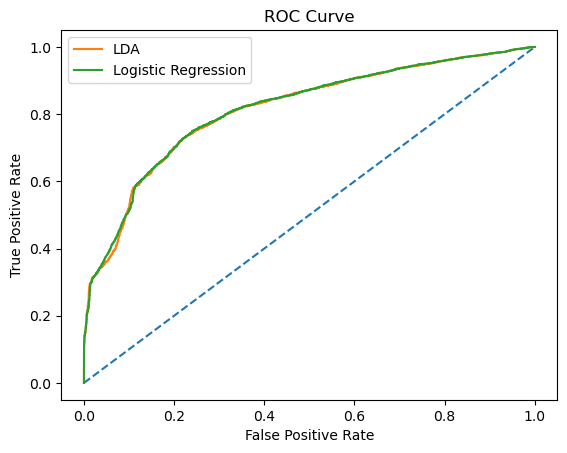

In [12]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_title("ROC Curve")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.plot((0,1), (0,1), linestyle = '--')

y_train_cv_score = cross_val_predict(lda_clf, X_train_transformed, y_train, cv = 10, method = "decision_function")
tpr, fpr, thresholds = roc_curve(y_train, y_train_cv_score)
ax.plot(tpr, fpr, linestyle = '-', label = "LDA")

y_train_cv_score = cross_val_predict(log_reg, X_train_transformed, y_train, cv = 10, method = "decision_function")
tpr, fpr, thresholds = roc_curve(y_train, y_train_cv_score)
ax.plot(tpr, fpr, linestyle = '-', label = "Logistic Regression")
ax.legend()
plt.show()

In [13]:
X_test = pd.read_csv("test.csv")
lda_clf = LinearDiscriminantAnalysis()
lda_clf.fit(X_train_transformed, y_train)
y_test_pred = lda_clf.predict(X_test_transformed).reshape(-1,1)
submission_arr = np.concatenate([X_test.loc[:,"PassengerId"].values.reshape(-1,1),y_test_pred], axis = 1)
submission_df = pd.DataFrame(submission_arr, columns = ["PassengerId","Transported"])
submission_df.to_csv("submission.csv", index = False)